In [1]:
import numpy as np

from matplotlib import pyplot as plt

from snn.graphs import plot_network
from snn.spiking_network import SpikingNetwork

from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY

## Linear output

In [2]:
clk_freq = 1536000

network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -200
neuron.activation_function = IDENTITY
neuron.membrane_should_reset = False
network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

test_size = 100000
x1 = np.ones(test_size) * 50
network.input_full_data(x1)

spikes = network.neurons[-1].out_spikes(False, test_size)

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


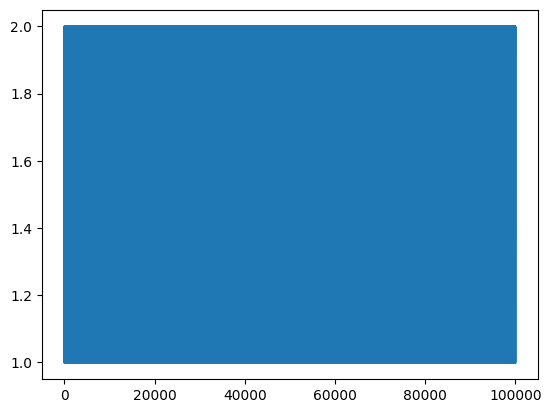

In [3]:
# cspikes = spikes.cumsum()
cspikes = np.convolve(spikes, np.ones(3, dtype=int), 'valid')

plt.plot(np.linspace(0, test_size, len(cspikes)), cspikes)

## Max output Neuron

In [4]:
def generate_w(size, prob):
    return (np.random.random(size) < prob).astype(int)


def multiple_w0(cycles, w_size):
    return np.concatenate([generate_w(w_size, ((np.sin(i)*75) + 250)/325) for i in np.linspace(0, cycles*2*np.pi, int(cycles*2*np.pi*w_size))])


def multiple_w1(cycles, w_size):
    return np.concatenate([generate_w(w_size, (((-np.sin(i))*75) + 250)/325) for i in np.linspace(0, cycles*2*np.pi, int(cycles*2*np.pi*w_size))])

W = 300
spikes_input = np.stack([multiple_w0(4, W), multiple_w1(4, W)]).T
print(spikes_input[:, 0].sum(), spikes_input[:, 1].sum())

1739803 1740645


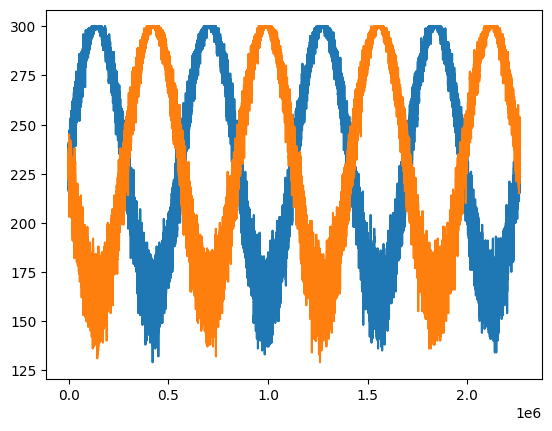

In [5]:
y0 = np.convolve(spikes_input[:, 0], np.ones(W, dtype=int), 'valid')
y1 = np.convolve(spikes_input[:, 1], np.ones(W, dtype=int), 'valid')
plt.plot(y0)
plt.plot(y1)

In [6]:
from snn.spiking_neuron import BINARY

clk_freq = 1536000

network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -.1
neuron.synapses_weights = np.array([5, 5], dtype=np.float64)
neuron.leakage_factor = 5
neuron.leakage_period = 72
neuron.threshold_pulse = 300
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
neuron.activation_function = BINARY

time_to_learn = 2.5e-3
A_LTP = .00025
A_LTD = -.00015
tau = network.clk_freq * time_to_learn / 2
neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 100, 0)

network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)
network.log_membrane_potential(-1)

In [7]:

weights = [0] * len(spikes_input)
for i, spikes in enumerate(spikes_input):
    network.input(spikes)
    weights[i] = neuron.synapses_weights
weights = np.array(weights)

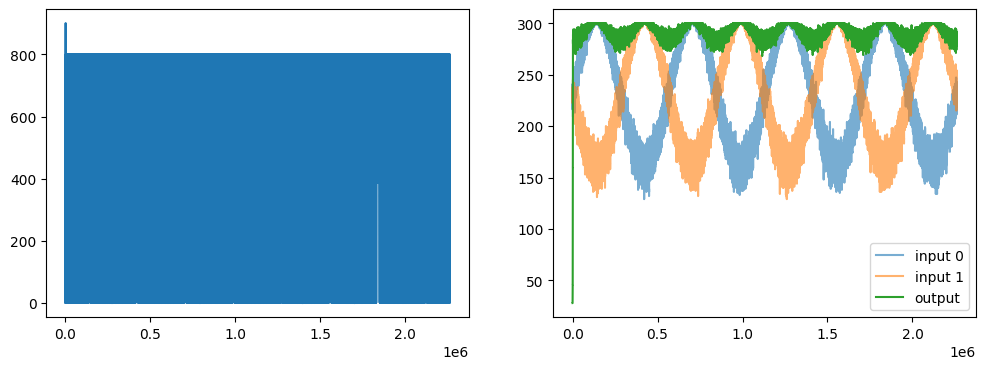

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(neuron.membrane_potential_graph())

y_output = np.convolve(neuron.out_spikes(False, len(spikes_input)), np.ones(W, dtype=int), 'valid')
axs[1].plot(y0, label='input 0', alpha=.6)
axs[1].plot(y1, label='input 1', alpha=.6)
axs[1].plot(y_output, label='output', alpha=1)
axs[1].legend()

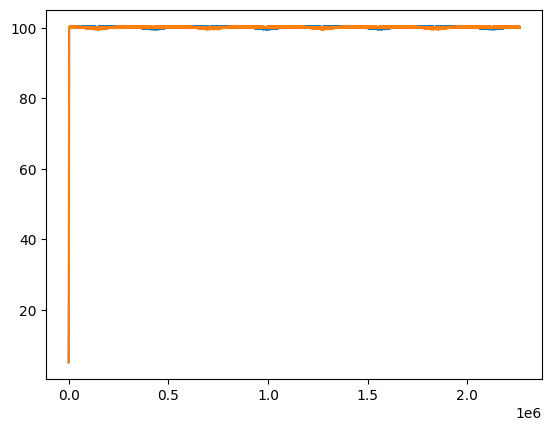

In [9]:
plt.plot(weights[:, 0])
plt.plot(weights[:, 1])

## Resonator with maximum and phase shifting

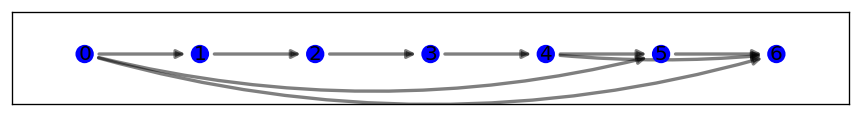

In [63]:
from snn.resonator import lp_by_lf, freq_of_resonator


def create_custom_resonator(freq0, clk_freq, lf, weight, theta):
    lp = lp_by_lf(lf, freq0, clk_freq)

    network = SpikingNetwork(clk_freq)
    network.add_amplitude(10000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    for i in range(4):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = lf
        neuron.leakage_period = lp
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # min neuron
    neuron = create_SCTN()
    neuron.theta = -.1
    neuron.synapses_weights = np.array([15, 15], dtype=np.float64)
    neuron.leakage_factor = 5
    neuron.leakage_period = 72
    neuron.threshold_pulse = 300
    neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    neuron.activation_function = BINARY
    time_to_learn = 2.5e-5
    A_LTP = .0025
    A_LTD = -.0015
    tau = network.clk_freq * time_to_learn / 2
    neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 75, 0)
    network.add_layer(SCTNLayer([neuron]))
    network.connect_by_id(0, 5)

    # x1 + x2 - 2min(x1, x2)
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([-2, 1, 1], dtype=np.float64)
    neuron.leakage_factor = lf
    neuron.leakage_period = lp
    neuron.threshold_pulse = 2
    neuron.theta = -.1
    neuron.activation_function = BINARY
    network.add_layer(SCTNLayer([neuron]))

    network.connect_by_id(0, 6)
    network.connect_by_id(4, 6)
    return network

resonator = create_custom_resonator(104, 1536000, 5, 10, -5)
plot_network(resonator)

In [64]:
def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0, cycles=5):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((8+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (8/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

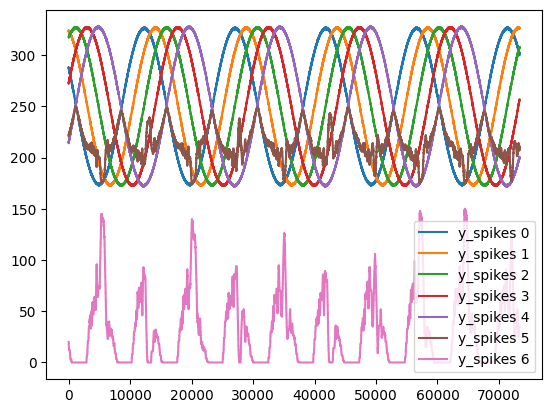

In [65]:
freq0 = 104
resonator = create_custom_resonator(freq0, 1536000, 5, 10, -5)
duration = .6
spikes_window_size = 500

for i in range(7):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)
for i in range(7):
# for i in [0, 4]:
    try:
        y_spikes = neuron_output(resonator.neurons[i], spikes_window_size, duration, freq0)
    except ValueError:
        print(f'neuron {i} didnt emit spikes')
        continue
    plt.plot(y_spikes, label=f'y_spikes {i}')
plt.legend()

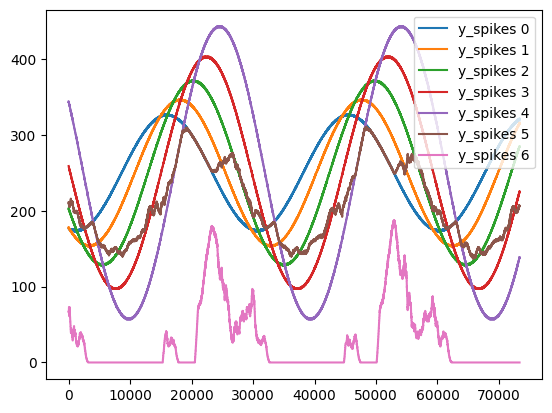

In [66]:
freq0 = 104
resonator = create_custom_resonator(freq0, 1536000, 5, 10, -5)
duration = .6
spikes_window_size = 500

for i in range(7):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0/2)
for i in range(7):
# for i in [0, 4]:
    try:
        y_spikes = neuron_output(resonator.neurons[i], spikes_window_size, duration, freq0)
    except ValueError:
        print(f'neuron {i} didnt emit spikes')
        continue
    plt.plot(y_spikes, label=f'y_spikes {i}')
plt.legend()

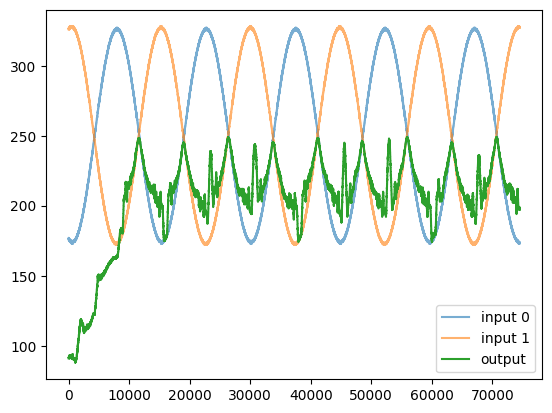

In [24]:
from snn.spiking_neuron import BINARY

clk_freq = 1536000
duration = .6

s_ts = resonator.neurons[0].out_spikes()
s0 = np.zeros(int(clk_freq * duration))
s0[s_ts] = 1
s0 = s0[25000:100000]

s_ts = resonator.neurons[4].out_spikes()
s4 = np.zeros(int(clk_freq * duration))
s4[s_ts] = 1
s4 = s4[25000:100000]

y0 = np.convolve(s0, np.ones(spikes_window_size, dtype=int), 'valid')
y1 = np.convolve(s4, np.ones(spikes_window_size, dtype=int), 'valid')
plt.plot(y0, label='input 0', alpha=.6)
plt.plot(y1, label='input 1', alpha=.6)

spikes_input = np.stack([s0, s4]).T
network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -.1
neuron.synapses_weights = np.array([15, 15], dtype=np.float64)
neuron.leakage_factor = 5
neuron.leakage_period = 72
neuron.threshold_pulse = 300
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
neuron.activation_function = BINARY
time_to_learn = 2.5e-5
A_LTP = .0025
A_LTD = -.0015
tau = network.clk_freq * time_to_learn / 2
neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 75, 0)

network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

weights = [0] * len(spikes_input)
for i, spikes in enumerate(spikes_input):
    network.input(spikes)
    weights[i] = neuron.synapses_weights
weights = np.array(weights)

y_output = np.convolve(neuron.out_spikes(False, len(s0)), np.ones(spikes_window_size, dtype=int), 'valid')
plt.plot(y_output, label='output', alpha=1)
plt.legend()

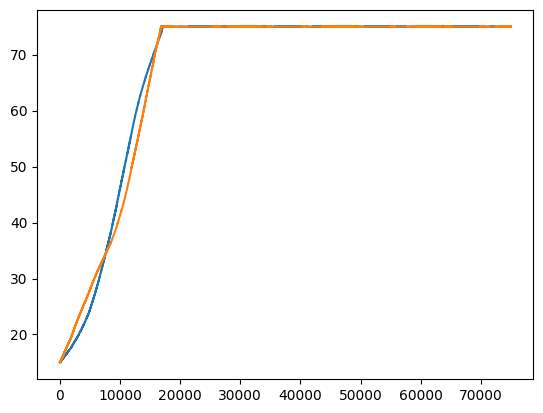

In [25]:
plt.plot(weights[:, 0])
plt.plot(weights[:, 1])

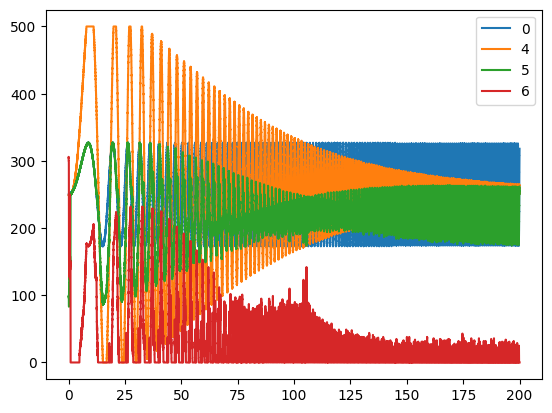

In [68]:
from snn.resonator import test_resonator_on_chirp

start_freq = 0
spectrum = 200
spikes_window_size = 500
# best_params = base_params

resonator = create_custom_resonator(104, 1536000, 5, 10, -5)
for i in range(7):
    resonator.log_out_spikes(i)

step = 1 / 10000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

for i in [0, 4, 5, 6]:
    spikes_neuron = resonator.neurons[i]
    y_spikes = spikes_neuron.out_spikes(False, test_size)
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
    # print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

    # best_lp = lp_by_lf(lf, freq0, clk_freq)
    # f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
    # plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
    plt.plot(x, y_spikes, label=f'{i}')
plt.legend()

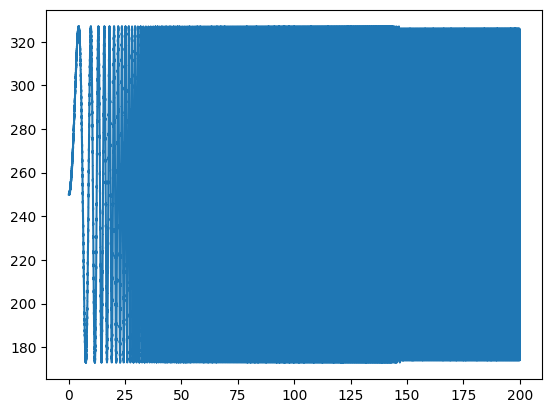

In [16]:
spikes_neuron = resonator.neurons[0]
y_spikes = spikes_neuron.out_spikes(False, test_size)
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
# print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

# best_lp = lp_by_lf(lf, freq0, clk_freq)
# f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
# plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
plt.plot(x, y_spikes, label=f'{i}')

In [1]:
1+1

2